In [109]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt

# Import scikit-learn functions
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV


# Import scikit-plot functions
#from scikitplot.metrics import plot_roc_curve
#from scikitplot.metrics import plot_precision_recall_curve
#from scikitplot.metrics import plot_calibration_curve

# Import SciPy function
from scipy.spatial import distance

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt

# Import scikit-learn functions
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV


# Import scikit-plot functions
#from scikitplot.metrics import plot_roc_curve
#from scikitplot.metrics import plot_precision_recall_curve
#from scikitplot.metrics import plot_calibration_curve

# Import SciPy function
from scipy.spatial import distance

In [110]:
df = pd.read_csv('../dataframe/dataModelo.csv')

In [111]:
df.head()

,x_est,y_est,distancia_est,angulo_est,remate_asistido,cabeza,penal,remate_tiro_esquina,remate_tiro_libre,remate_contraataque,remate_balon_parado,remate_jugada_lateral,remate_jugada_regular,gol
0,0.896,0.515,0.105076,0.271171,True,True,False,False,False,False,False,False,True,False
1,0.880,0.736,0.264756,0.053579,False,False,False,False,False,False,False,False,True,False
2,0.941,0.581,0.100210,0.201128,True,False,False,False,False,False,True,False,False,False
3,0.876,0.401,0.158673,0.152746,True,True,False,False,False,False,True,False,False,False
4,0.858,0.668,0.219973,0.091548,True,False,False,False,False,False,False,False,True,False


In [112]:
df.shape

(9245, 14)

In [113]:
len(df[df['gol']==True]) ### 955 remates que acaban en gol

955

In [114]:
len(df[df['gol']==False]) ### 8290 remates que NO acaban en gol
### Las clases que queremos predecir se encuentran muy desbalanceadas. Se debería aplicar técnica de rebalaceo.

8290

In [115]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [116]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# XG Boost

In [117]:
xgb = XGBClassifier(objective='binary:logistic', max_depth=5, n_estimators=100)
xgb.fit(x_test, y_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [118]:
# For each shot, predict the probability of the shot resulting in a goal
pred = xgb.predict_proba(x_test)

In [119]:
y_total = np.count_nonzero(y_train >= 0 )
y_positive = np.sum(y_train)

print('The training set contains {} examples of which {} are positives.'.format(y_total, y_positive))

The training set contains 7396 examples of which 748 are positives.


In [120]:
pred

array([[0.57491004, 0.42508996],
       [0.7838627 , 0.2161373 ],
       [0.9594284 , 0.04057155],
       ...,
       [0.9430259 , 0.05697409],
       [0.917885  , 0.082115  ],
       [0.9943358 , 0.00566425]], dtype=float32)

In [121]:
pred.shape

(1849, 2)

In [122]:
auc_roc = roc_auc_score(y_test, pred[:,1])

print('Our classifier obtains an AUC-ROC of {}.'.format(auc_roc))

Our classifier obtains an AUC-ROC of 0.9761866934985612.


In [123]:
####
auc_pr_baseline = y_positive / y_total

print('The baseline performance for AUC-PR is {}.'.format(auc_pr_baseline))

The baseline performance for AUC-PR is 0.10113574905354246.


In [124]:
auc_pr = average_precision_score(y_test, pred[:,1])

print('Our classifier obtains an AUC-PR of {}.'.format(auc_pr))

Our classifier obtains an AUC-PR of 0.8472876682370445.


In [125]:
score = xgb.score(x_test, y_test)
print(score)

0.9410492157923201


# Cross-validation

In [126]:
# xG Boost
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(xgb, x_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.897 (0.012)


# ROC

In [127]:
auc_roc = roc_auc_score(y_test, pred[:, 1])

print('Our classifier obtains an AUC-ROC of {}.'.format(auc_roc))

Our classifier obtains an AUC-ROC of 0.9761866934985612.


# Aplicar modelo a df (remates)

In [128]:
X.shape

(9245, 13)

In [129]:
y.shape

(9245,)

In [130]:
pred2 = xgb.predict_proba(X)

In [131]:
pred2

array([[0.9617023 , 0.03829769],
       [0.99155754, 0.00844247],
       [0.4409175 , 0.5590825 ],
       ...,
       [0.9635012 , 0.03649876],
       [0.94657594, 0.05342406],
       [0.26431084, 0.73568916]], dtype=float32)

In [132]:
pred2.shape

(9245, 2)

In [133]:
xg = pred2[:,1]

In [134]:
xg

array([0.03829769, 0.00844247, 0.5590825 , ..., 0.03649876, 0.05342406,
       0.73568916], dtype=float32)

# Nueva columna con xg

In [135]:
xg = pd.DataFrame({'xg':xg})

In [136]:
xg.tail()

,xg
9240,0.137197
9241,0.632518
9242,0.036499
9243,0.053424
9244,0.735689


In [137]:
xg.to_csv('../dataframe/xg.csv')

# Valor de cada feature en el modelo

In [138]:
print(xgb.feature_importances_)

[0.05502242 0.05063434 0.1005507  0.0969018  0.04775779 0.21725173
 0.16664058 0.0638188  0.03147414 0.0801335  0.03005286 0.
 0.05976132]


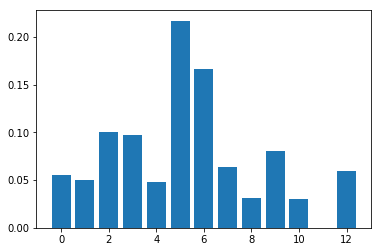

In [139]:
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()